In [1]:
%reload_ext autoreload
%autoreload 2

## Import packages

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import (
    replay_run,
    replay_participation_all_replays,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import logging

logging.basicConfig(level=logging.INFO)


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## default plotting

In [3]:
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## Load replay data

In [4]:
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_v7"
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'

replay_df = replay_run.load_results(save_path, pre_task_post=False)


## run replay participation analysis

replay_participation_all_replays

In [9]:
# replay_participation_all_replays.handle_epochs(
#     "Z:\Data\GrosmarkAD\Achilles\Achilles_10252013",
#     ["sleep", "linear", "sleep"],
#     ["linear", "sleep"],
#     ["sleep", "linear"],
)


(<EpochArray at 0x16aa1e0dd00: 2 epochs> of length 9:41:01:103 hours,
 array(['sleep', 'linear_sleep'], dtype=object))

In [10]:
# temp_df = replay_participation_all_replays.run("Z:\Data\GrosmarkAD\Achilles\Achilles_10252013",
#     replay_df=replay_df,
#     replay_save_path=save_path,
#     environments=["sleep", "linear", "sleep"],
#     min_env_criteria = ["sleep", "linear"],
#     epochs_to_combine=["linear", "sleep"])

# get many types of participation and firing

* combine linear and following sleep sessions to calc participation

* if no post sleep, only calc on linear track

* capture pre sleep participation



In [14]:
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_v7"
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'

# save_path_cur_analysis = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_sessions_task_post"
# )
save_path_cur_analysis = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_all_sessions_sleep_task_sleep"
)
batch_analysis.run(
    replay_df,
    save_path_cur_analysis,
    replay_participation_all_replays.run,
    parallel=True,
    verbose=True,
    overwrite=False,
    skip_if_error=False,
    replay_df=replay_df,
    replay_save_path=save_path,
    environments=["sleep", "linear", "sleep"],
    min_env_criteria = ["sleep", "linear"],
    epochs_to_combine=["linear", "sleep"],
    alpha=0.05,
    min_spk_count=0,
)

# read back in
# save_path_cur_analysis = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_sessions_task_post"
# )
sessions = glob.glob(save_path_cur_analysis + os.sep + "*.pkl")
par_df = pd.DataFrame()
for session in sessions:
    with open(session, "rb") as f:
        results = pickle.load(f)
    par_df = pd.concat([par_df, results])


100%|██████████| 89/89 [02:15<00:00,  1.52s/it] 


## add deep sup class from deep sup distance

In [15]:
par_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(par_df)
for basepath in par_df.basepath.unique():
    par_df.loc[par_df.basepath == basepath, "animal_id"] = loading.get_animal_id(basepath)


## plot replay partic prob. between layers

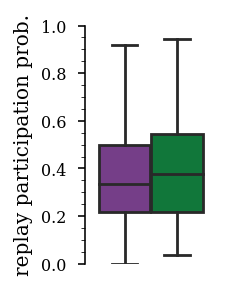

In [70]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

# keep_idx = (par_df.n_replays > 30) & (~par_df.basepath.str.contains('GirardeauG'))
keep_idx = (par_df.n_replays > 30) & (par_df.epoch.str.contains("linear"))

sns.boxplot(
    x="epoch",
    y="replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
# sns.stripplot(
#     x="epoch",
#     y="replay_par",
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     data=par_df[keep_idx],
#     dodge=True,
#     color="k",
#     size=3,
#     alpha=0.5,
# )
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("replay participation prob.")

ax.set_ylim(0,1)
plt.savefig(
    os.path.join(fig_save_path, "replay_participation_05_19_22.svg"),
    dpi=300,
    bbox_inches="tight",
)


## See replay firing rate gain

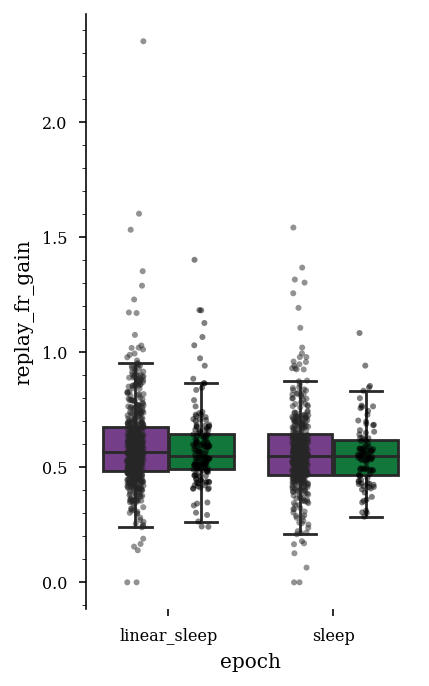

In [71]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

par_df["replay_fr_gain"] = par_df["replay_fr"] / par_df["non_replay_fr"]

# keep_idx = (par_df.n_replays > 30) & (~par_df.basepath.str.contains('GirardeauG'))
keep_idx = (par_df.n_replays > 30)

sns.boxplot(
    x="epoch",
    y="replay_fr_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="replay_fr_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
# ax.set_xlabel("")
# ax.set_ylabel("non_replay_fr firing rate (Hz)")

# ax.set_yscale("log")
# plt.savefig(
#     os.path.join(fig_save_path, "replay_fr_05_11_22.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )
# par_df[keep_idx].basepath.unique()

## Test python mixed lm model

In [72]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder

temp_df = par_df[(par_df.deepSuperficial != "middle") & (par_df.n_replays > 30)]

lbl=LabelEncoder()
temp_df['basepath_encoded'] = lbl.fit_transform(temp_df[['basepath']])
temp_df['deepSuperficial_encoded'] = lbl.fit_transform(temp_df[['deepSuperficial']])

temp_df["Intercept"] = 1
exog = temp_df[["Intercept", "deepSuperficial_encoded"]]
md = sm.MixedLM(temp_df["replay_par"], exog, groups=temp_df["basepath_encoded"], exog_re=exog["Intercept"])
mdf = md.fit()
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    replay_par
No. Observations:    1232       Method:                REML      
No. Groups:          29         Scale:                 0.0356    
Min. group size:     8          Log-Likelihood:        268.6480  
Max. group size:     140        Converged:             Yes       
Mean group size:     42.5                                        
-----------------------------------------------------------------
                        Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.395    0.019 21.075 0.000  0.359  0.432
deepSuperficial_encoded 0.041    0.015  2.700 0.007  0.011  0.071
Intercept Var           0.009    0.015                           



c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


## Forward / Reverse 

make wide to long df

In [75]:
keep_idx = (par_df.n_replays > 30) & (par_df.epoch.str.contains("linear"))

par_df_long = pd.melt(
    par_df[keep_idx],
    id_vars=["basepath", "UID", "deepSuperficial"],
    value_vars=["forward_replay_par", "reverse_replay_par"],
    var_name="replay_type",
    value_name="replay_participation",
)
par_df_long


,basepath,UID,deepSuperficial,replay_type,replay_participation
0,Z:\Data\AYAold\AYA6\day17,25,Superficial,forward_replay_par,0.187500
1,Z:\Data\AYAold\AYA6\day17,27,Deep,forward_replay_par,0.312500
2,Z:\Data\AYAold\AYA6\day17,29,Superficial,forward_replay_par,0.062500
3,Z:\Data\AYAold\AYA6\day17,30,Superficial,forward_replay_par,0.125000
4,Z:\Data\AYAold\AYA6\day17,31,Superficial,forward_replay_par,0.000000
...,...,...,...,...,...
2079,Z:\Data\Kenji\ec014.459_480,75,Deep,reverse_replay_par,0.620690
2080,Z:\Data\Kenji\ec014.459_480,76,Deep,reverse_replay_par,0.413793
2081,Z:\Data\Kenji\ec014.459_480,77,Deep,reverse_replay_par,0.241379
2082,Z:\Data\Kenji\ec014.459_480,82,Deep,reverse_replay_par,0.500000


### look at forward and reverse

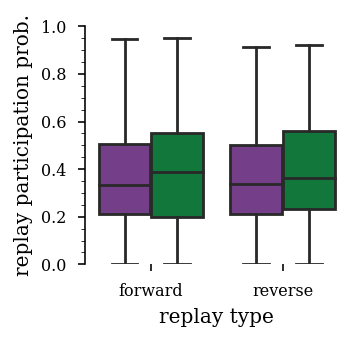

In [77]:
# fig = plt.figure(
#     figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
# )
w,h = functions.set_size("thesis", fraction=0.2, subplots=(3, 1))

fig = plt.figure(
    figsize=(w*2,h), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

g=sns.boxplot(
    x="replay_type",
    y="replay_participation",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_long,
    showfliers=False,
)
ax = plt.gca()
ax.get_legend().remove()
sns.despine()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
# ax.get_legend().remove()
# ax.set_xlabel("")
# plt.xticks(['forward','reverse'], rotation='vertical')
ax.set_ylabel("replay participation prob.")
ax.set_xlabel("replay type")
g.set_xticklabels(['forward','reverse'])

ax.set_ylim(0,1)

plt.savefig(
    os.path.join(fig_save_path, "replay_participation_for_rev.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [109]:
par_df_long['replay_type_ca1_layer'] = par_df_long['replay_type'] + '_' + par_df_long['deepSuperficial']
par_df_long['replay_type_ca1_layer'].unique()

array(['forward_replay_par_Superficial', 'forward_replay_par_Deep',
       'forward_replay_par_middle', 'reverse_replay_par_Superficial',
       'reverse_replay_par_Deep', 'reverse_replay_par_middle'],
      dtype=object)

### paired plot of forward and reverse

<AxesSubplot:xlabel='replay_type', ylabel='replay_participation'>

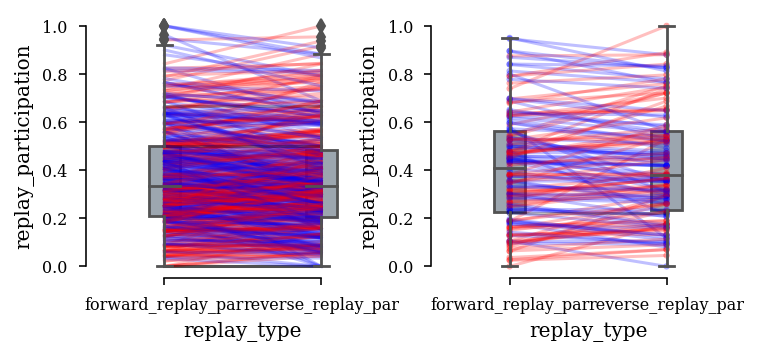

In [64]:
import pingouin as pg

fig, axs = plt.subplots(1, 2, figsize=functions.set_size(
    'thesis', fraction=1, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace=.2, wspace=.1)
axs = axs.ravel()

ax = plt.gca()
par_df_long["basepath_UID"] = par_df_long.basepath + "_" + par_df_long.UID.astype(str)

pg.plot_paired(
    data=par_df_long[par_df_long.deepSuperficial == "Deep"],
    dv="replay_participation",
    within="replay_type",
    subject="basepath_UID",
    ax=axs[0],
    pointplot_kwargs={"alpha": 0.25, "s": .5},colors=['r','k','b'],
)
pg.plot_paired(
    data=par_df_long[par_df_long.deepSuperficial == "Superficial"],
    dv="replay_participation",
    within="replay_type",
    subject="basepath_UID",
    ax=axs[1],
    pointplot_kwargs={"alpha": 0.25},colors=['r','k','b']
)

In [110]:
# par_df["forward_reverse_ratio"] = (
#     par_df.forward_replay_par - par_df.reverse_replay_par
# ) / (par_df.forward_replay_par + par_df.reverse_replay_par)

# par_df["forward_reverse_ratio"] = (
#     par_df.forward_replay_par - par_df.reverse_replay_par
# )

par_df["forward_reverse_ratio"] = (
    par_df.forward_replay_par / par_df.reverse_replay_par
)

In [111]:
(par_df[par_df.deepSuperficial == "Deep"].forward_reverse_ratio > 1).sum()
(par_df[par_df.deepSuperficial == "Deep"].forward_reverse_ratio < 1).sum()

(par_df[par_df.deepSuperficial == "Superficial"].forward_reverse_ratio > 1).sum(),(par_df[par_df.deepSuperficial == "Superficial"].forward_reverse_ratio < 1).sum()

(129, 130)

### Forward / Reverse for main fig

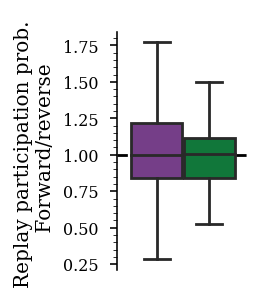

In [112]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    x="epoch",
    y="forward_reverse_ratio",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
    # boxprops=dict(alpha=.7)

# sns.stripplot(
#     x="epoch",
#     y="forward_reverse_ratio",
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     data=par_df[keep_idx],
#     dodge=True,
#     color="k",
#     size=3,
#     alpha=0.5,
# )
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
ax.axhline(1, linestyle="--", color="k",zorder=-1000)

ax.set_ylabel("Replay participation prob. \n Forward/reverse")

plt.savefig(
    os.path.join(fig_save_path, "replay_participation_replay_type.svg"),
    dpi=300,
    bbox_inches="tight",
)

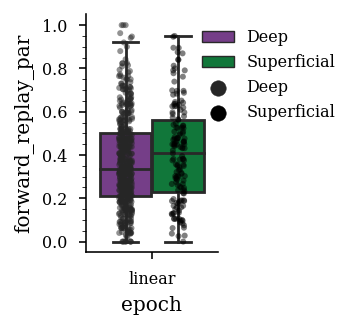

In [68]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="epoch",
    y="forward_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="forward_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# plt.yscale("log")

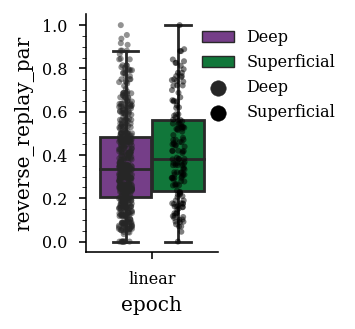

In [69]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="epoch",
    y="reverse_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="reverse_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# plt.yscale("log")

## calculate firing rate gain

$replayGain = \frac{replay fr}{avg fr}$

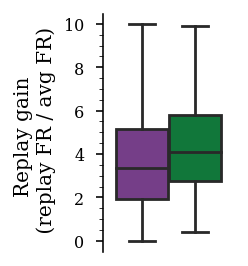

In [63]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

# par_df["replay_df_gain_avg_to_replay"] = (par_df.replay_fr-par_df.non_ripple_avg_fr)/(par_df.replay_fr+par_df.non_ripple_avg_fr)
par_df["replay_df_gain_avg_to_replay"] = par_df.replay_fr / par_df.non_ripple_avg_fr

keep_idx = (
    (par_df.n_replays > 30)
    & (par_df.animal_id != "Rat08")
    & (par_df.animal_id != "Gatsby")
    & (par_df.epoch.str.contains("linear"))
)

sns.boxplot(
    x="epoch",
    y="replay_df_gain_avg_to_replay",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)

# sns.stripplot(
#     x="epoch",
#     y="replay_df_gain_avg_to_replay",
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     data=par_df[keep_idx],
#     dodge=True,
#     color="k",
#     size=3,
#     alpha=0.5,
# )
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)

sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
# ax.axhline(1, linestyle="--", color="k",zorder=-1000)
ax.set_ylabel("Replay gain \n (replay FR / avg FR)")

plt.savefig(
    os.path.join(fig_save_path, "replay_fr_over_avg_fr.svg"),
    dpi=300,
    bbox_inches="tight",
)

<AxesSubplot:xlabel='animal_id', ylabel='replay_df_gain_avg_to_replay'>

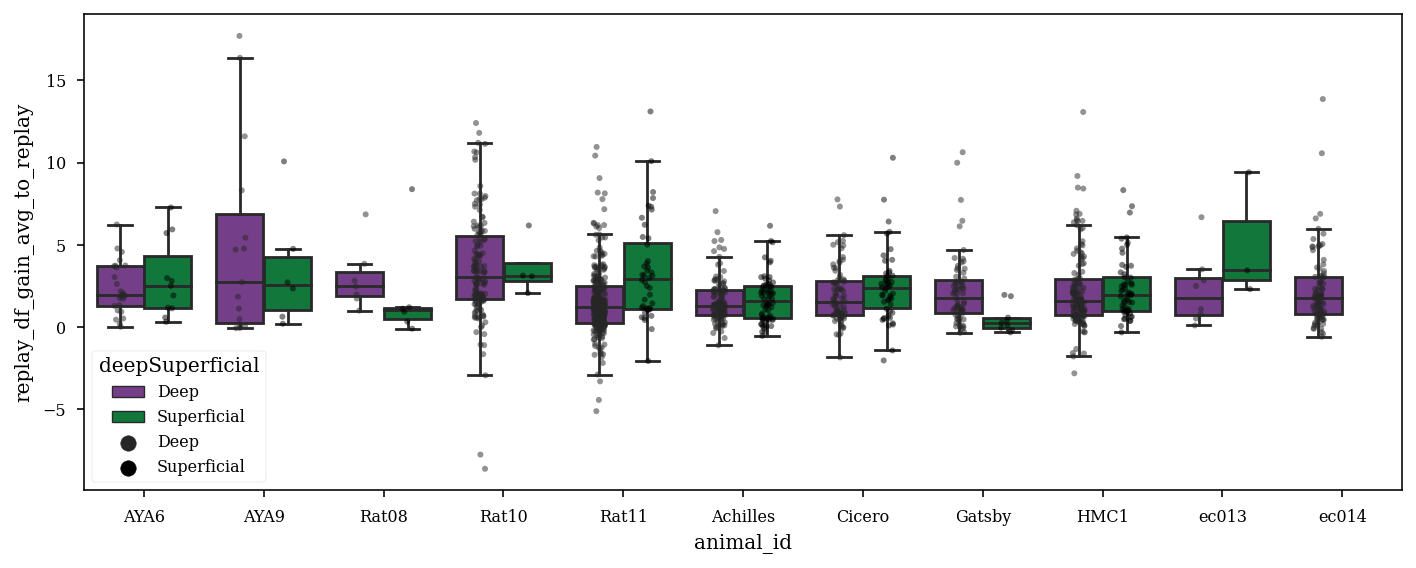

In [41]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=2, subplots=(3, 5)), edgecolor=None
)
par_df["replay_df_gain_avg_to_replay"] = (par_df.replay_fr-par_df.non_ripple_avg_fr)

sns.boxplot(
    x="animal_id",
    y="replay_df_gain_avg_to_replay",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="animal_id",
    y="replay_df_gain_avg_to_replay",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)

In [52]:
par_df.epoch.unique()

array(['sleep', 'linear', 'linear_sleep'], dtype=object)

In [50]:
for animal_id in par_df[keep_idx].animal_id.unique():
    print(animal_id, ' deep ', sum((par_df[keep_idx].animal_id == animal_id) & (par_df[keep_idx].deepSuperficial == "Deep")))
    print(animal_id, ' sup ', sum((par_df[keep_idx].animal_id == animal_id) & (par_df[keep_idx].deepSuperficial == "Superficial")))


AYA6  deep  26
AYA6  sup  11
AYA9  deep  15
AYA9  sup  6
Rat08  deep  7
Rat08  sup  6
Rat10  deep  142
Rat10  sup  4
Rat11  deep  279
Rat11  sup  44
Achilles  deep  118
Achilles  sup  68
Cicero  deep  82
Cicero  sup  50
Gatsby  deep  67
Gatsby  sup  9
HMC1  deep  138
HMC1  sup  57
ec013  deep  8
ec013  sup  3
ec014  deep  92
ec014  sup  0


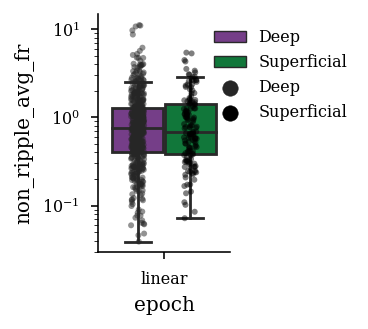

In [115]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="epoch",
    y="non_ripple_avg_fr",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)

sns.stripplot(
    x="epoch",
    y="non_ripple_avg_fr",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.yscale("log")

## Ripple gain pre-sleep norm

$replayGain = \frac{ReplayFr}{preSleepAvgFr}$


In [20]:
par_df_wide = pd.pivot(
    par_df[keep_idx], index=["UID","basepath","deepSuperficial"], columns="epoch", values=["replay_fr","avg_fr"]
).reset_index()
par_df_wide

par_df_wide["replay_gain"] = par_df_wide["replay_fr"]["linear_sleep"] / par_df_wide["avg_fr"]["sleep"]
# par_df_wide["avg_fr"]["sleep"]
par_df_wide

UID                                       basepath deepSuperficial  \
epoch                                                                       
0        1                      Z:\Data\AYAold\AYA9\day17            Deep   
1        1  Z:\Data\GrosmarkAD\Achilles\Achilles_11012013            Deep   
2        1      Z:\Data\GrosmarkAD\Cicero\Cicero_09102014            Deep   
3        1      Z:\Data\GrosmarkAD\Cicero\Cicero_09172014            Deep   
4        1      Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013     Superficial   
...    ...                                            ...             ...   
1050   295                             Z:\Data\HMC1\day10            Deep   
1051   296                             Z:\Data\HMC1\day10            Deep   
1052   297                             Z:\Data\HMC1\day10            Deep   
1053   298                             Z:\Data\HMC1\day10     Superficial   
1054   299                             Z:\Data\HMC1\day10     Superficial   

         replay_fr                 avg_fr           replay_gain  
epoch linear_sleep     sleep linear_sleep     sleep              
0         5.455461       NaN     0.824329       NaN         NaN  
1         1.294563  1.282216     0.610086  0.288619    4.485374  
2         2.747725  2.792113     0.507453  0.967435    2.840216  
3         2.457673  1.467998     0.725078  0.439106    5.596996  
4         1.189343       NaN     0.934158       NaN         NaN  
...            ...       ...          ...       ...         ...  
1050      2.630253  1.564651     0.665072  0.391450    6.719254  
1051      3.000711  2.242667     0.841719  0.470308    6.380309  
1052      7.742576  1.721117     3.545413  0.512140   15.118084  
1053      5.149369  6.258606     1.725940  2.017432    2.552437  
1054      2.667299  2.920683     0.936913  1.110565    2.401749  

[1055 rows x 8 columns]

In [21]:
par_df_wide[par_df_wide.basepath == "Z:\Data\GrosmarkAD\Achilles\Achilles_10252013"]
par_df[par_df.basepath == "Z:\Data\GrosmarkAD\Achilles\Achilles_10252013"].epoch.value_counts()

# par_df

sleep           104
linear_sleep    104
Name: epoch, dtype: int64

In [22]:
keep_idx = (par_df.n_replays > 30)

par_df_wide = pd.pivot(
    par_df[keep_idx], index=["UID","basepath","deepSuperficial"], columns="epoch", values=["replay_fr","avg_fr"]
).reset_index()

par_df_wide["replay_gain"] = par_df_wide["replay_fr"]["linear_sleep"] / par_df_wide["avg_fr"]["sleep"]
par_df_wide["constant"] = 1

for basepath in par_df_wide.basepath.unique():
    par_df_wide.loc[par_df_wide.basepath == basepath, "animal_id"] = loading.get_animal_id(basepath)
par_df_wide = par_df_wide[["UID", "basepath", "deepSuperficial", "animal_id", "replay_gain", "constant"]]
par_df_wide = par_df_wide[~np.isnan(par_df_wide.replay_gain)]
par_df_wide

,UID,basepath,deepSuperficial,animal_id,replay_gain,constant
epoch,,,,,,
1,1,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013,Deep,Achilles,4.485374,1
2,1,Z:\Data\GrosmarkAD\Cicero\Cicero_09102014,Deep,Cicero,2.840216,1
3,1,Z:\Data\GrosmarkAD\Cicero\Cicero_09172014,Deep,Cicero,5.596996,1
5,1,Z:\Data\Kenji\ec014.459_480,Deep,ec014,16.773367,1
8,2,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013,Deep,Achilles,1.464797,1
...,...,...,...,...,...,...
1050,295,Z:\Data\HMC1\day10,Deep,HMC1,6.719254,1
1051,296,Z:\Data\HMC1\day10,Deep,HMC1,6.380309,1
1052,297,Z:\Data\HMC1\day10,Deep,HMC1,15.118084,1


In [23]:
# describe par_df_wide
par_df_wide.describe()
print(par_df_wide.basepath.value_counts())
print(par_df_wide.deepSuperficial.value_counts())


Z:\Data\GrosmarkAD\Achilles\Achilles_10252013    104
Z:\Data\GrosmarkAD\Achilles\Achilles_11012013     90
Z:\Data\HMC1\day10                                78
Z:\Data\GrosmarkAD\Cicero\Cicero_09102014         55
Z:\Data\GirardeauG\Rat11\Rat11-20150331           52
Z:\Data\Kenji\ec014.459_480                       49
Z:\Data\GrosmarkAD\Cicero\Cicero_09172014         42
Z:\Data\GrosmarkAD\Gatsby\Gatsby_08022013         36
Z:\Data\GrosmarkAD\Cicero\Cicero_09012014         34
Z:\Data\GirardeauG\Rat11\Rat11-20150327           31
Z:\Data\GirardeauG\Rat11\Rat11-20150330           30
Z:\Data\GirardeauG\Rat11\Rat11-20150310           28
Z:\Data\GirardeauG\Rat11\Rat11-20150328           26
Z:\Data\GirardeauG\Rat10\Rat10-20140622           21
Z:\Data\GirardeauG\Rat10\Rat10-20140624           18
Z:\Data\GirardeauG\Rat11\Rat11-20150315           16
Z:\Data\GirardeauG\Rat10\Rat10-20140705           13
Z:\Data\GirardeauG\Rat10\Rat10-20140704           12
Name: basepath, dtype: int64
Deep           39

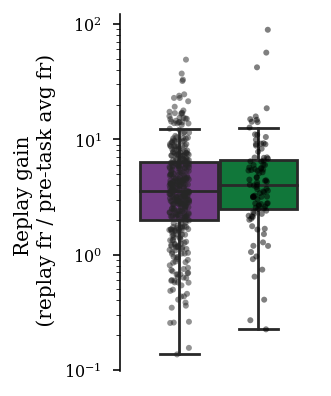

In [28]:

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.3, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="constant",
    y="replay_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_wide,
    showfliers=False,
)

sns.stripplot(
    x="constant",
    y="replay_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_wide,
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)

sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
# ax.axhline(1, linestyle="--", color="k",zorder=-1000)

ax.set_ylabel("Replay gain \n (replay fr / pre-task avg fr)")
plt.yscale("log")

In [27]:
par_df_wide.to_csv(
    r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_all_sessions_task_post_replay_gain.csv"
)

In [32]:
par_df.epoch.unique()

array(['sleep', 'linear', 'linear_sleep'], dtype=object)

## save csv

In [39]:
# par_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_task_post.csv")
# replay_participation_for_all_sessions_task_post
par_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_all_sessions_task_post.csv")


## visualize with dabest

In [24]:
temp_df_1 = pd.DataFrame()
keep_idx = (par_df.n_replays > 30)
par_df['basepath_UID'] = par_df.basepath + "_" + par_df.UID.astype(str)

temp_df_1['forward'] = par_df[keep_idx & (par_df.deepSuperficial=="Deep")].forward_replay_par.values
temp_df_1['reverse'] = par_df[keep_idx & (par_df.deepSuperficial=="Deep")].reverse_replay_par.values
temp_df_1['ID'] = par_df[keep_idx & (par_df.deepSuperficial=="Deep")].basepath_UID.values
temp_df_1['deepSuperficial'] = ["Deep"] * len(temp_df_1)

temp_df_2 = pd.DataFrame()
temp_df_2['forward'] = par_df[keep_idx & (par_df.deepSuperficial=="Superficial")].forward_replay_par.values
temp_df_2['reverse'] = par_df[keep_idx & (par_df.deepSuperficial=="Superficial")].reverse_replay_par.values
temp_df_2['ID'] = par_df[keep_idx & (par_df.deepSuperficial=="Superficial")].basepath_UID.values

temp_df_2['deepSuperficial'] = ["Superficial"] * len(temp_df_2)
temp_df = pd.concat([temp_df_1, temp_df_2],ignore_index=True)
temp_df

,forward,reverse,ID,deepSuperficial
0,0.312500,0.352941,Z:\Data\AYAold\AYA6\day17_27,Deep
1,0.125000,0.235294,Z:\Data\AYAold\AYA6\day17_33,Deep
2,0.187500,0.411765,Z:\Data\AYAold\AYA6\day17_36,Deep
3,0.437500,0.470588,Z:\Data\AYAold\AYA6\day17_37,Deep
4,0.375000,0.294118,Z:\Data\AYAold\AYA6\day17_40,Deep
...,...,...,...,...
666,0.777778,0.740741,Z:\Data\HMC1\day8_275,Superficial
667,0.619048,0.555556,Z:\Data\HMC1\day8_279,Superficial
668,0.450000,0.687500,Z:\Data\Kenji\ec013.634_653_61,Superficial
669,0.950000,0.812500,Z:\Data\Kenji\ec013.634_653_66,Superficial


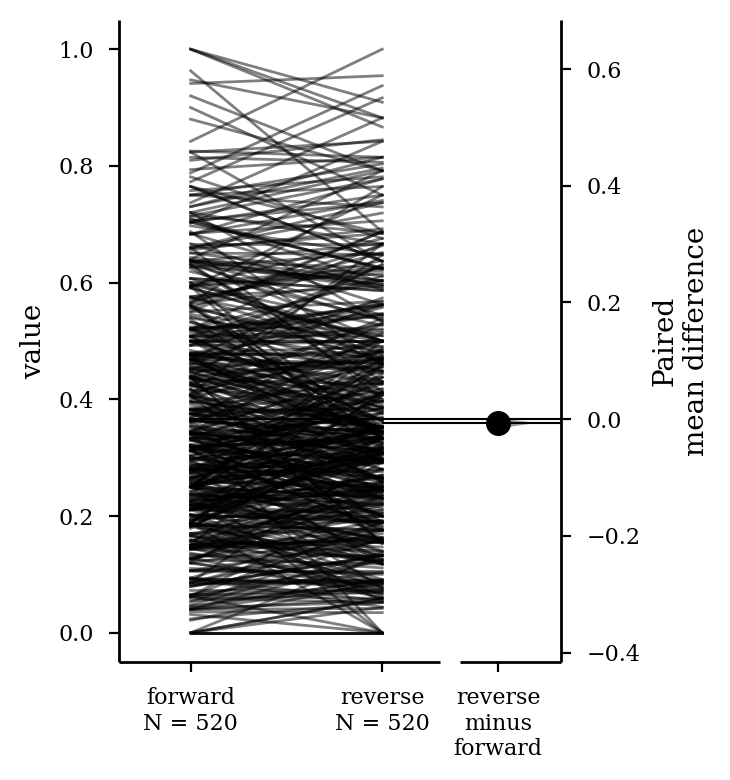

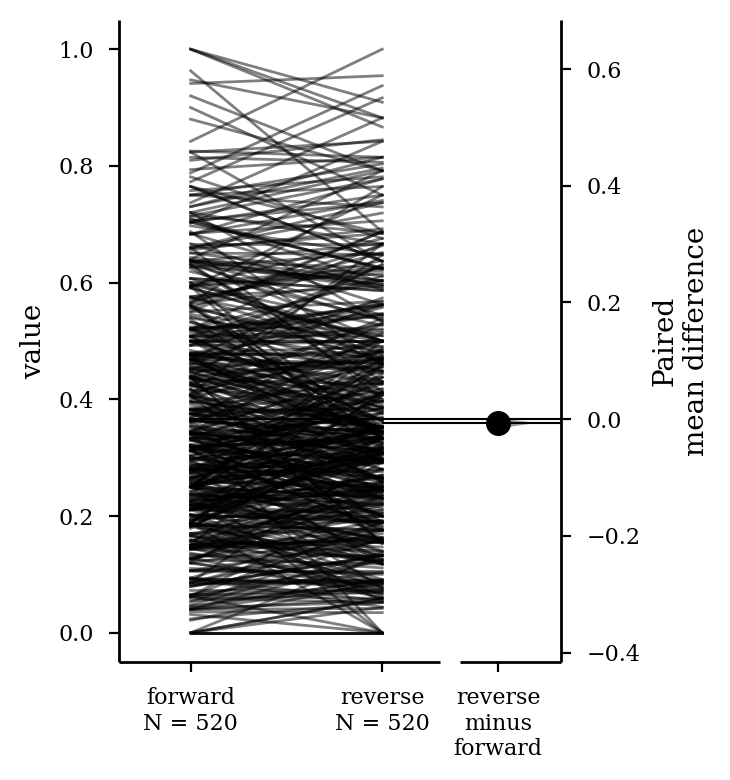

In [25]:
import dabest
multi_2group_paired = dabest.load(temp_df[temp_df['deepSuperficial'] == "Deep"], idx=("forward", "reverse"),
                                paired=True, id_col=("ID")
                                )
multi_2group_paired.mean_diff.plot()


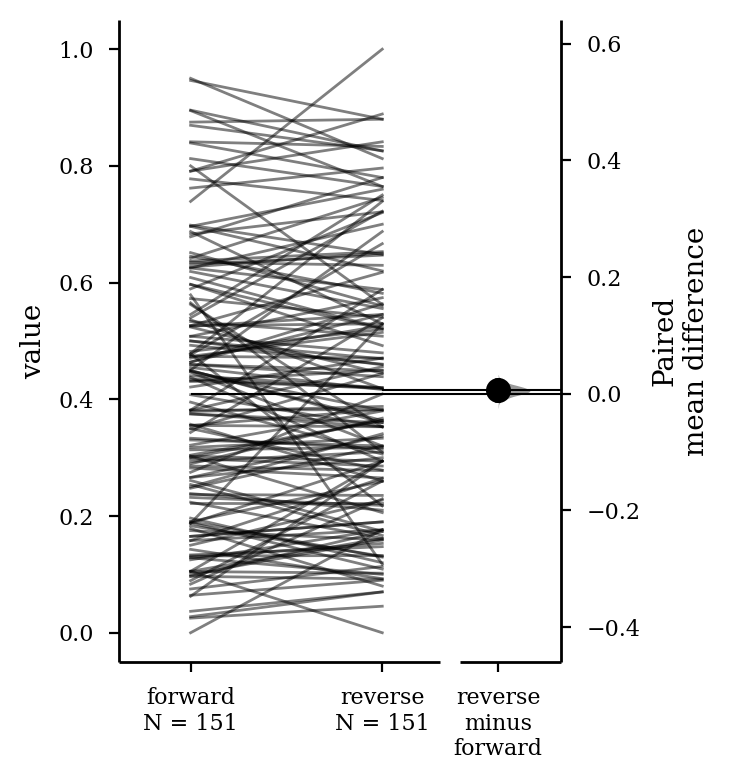

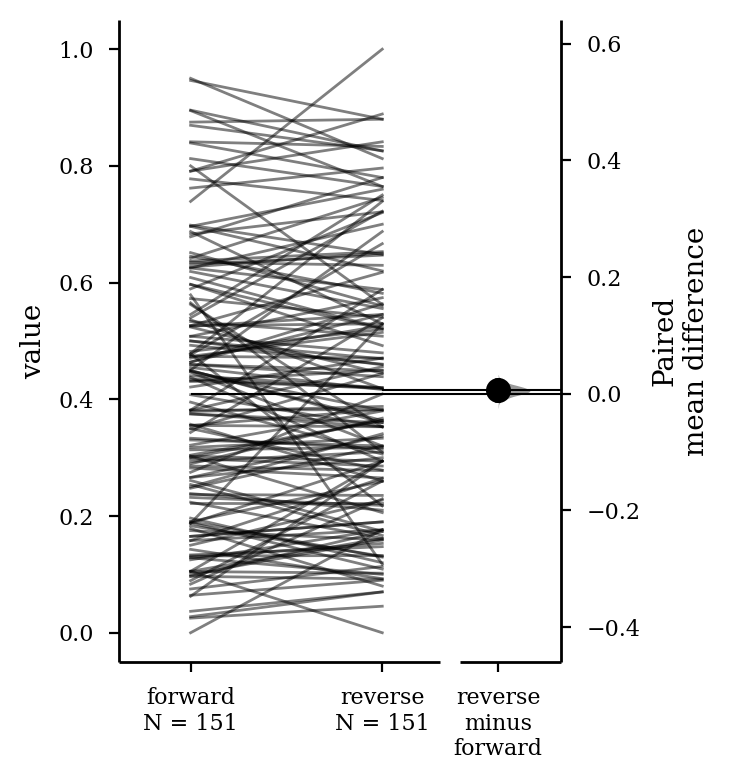

In [26]:
multi_2group_paired = dabest.load(temp_df[temp_df['deepSuperficial'] == "Superficial"], idx=("forward", "reverse"),
                                paired=True, id_col=("ID")
                                )
multi_2group_paired.mean_diff.plot()